# Tutorial on Variational Quantum Eigensolver (Part I)

---
This code was mostly based on Qiskit Variational Quantum Eigensolver Playground, you can find in [Github](https://github.com/JavaFXpert/vqe-playground). It was reduced as much as possible to analyze the core of the VQE Algorithm.  

In the coming paragraphs we are going to analyze all the code step by step. Please run all the cells in order.

To start we will be briefly explaining the algorithm and the technique behind the Variational Quantum Eigensolver (VQE). VQE is an hybrid quantum algorithm that leverages both classical and quantum computing. In the following figure you can see both elements of the algorithm clearly differentiated in Blue and Green.   
<img src="./img/VQE1.png" >

There are many ways to tune one or more parameters from the Quantum Circuit. In this example we will be finetuning the rotation angle of 25 different Rotation Gates through the Y axis. 
We will be finetuning the gates angle one by one, as a result you will see that we will run the optimization for at least 25 times, but the amount of gates to be tuned can be freely chosen as long as the rotations explore all the hilbert space of possible ansatz quantum states.

**NOTE:** In this simulation implementation, we calculate the energy (Expected value of the Hamiltonian for $ |\Psi\rangle $) clasically because we have access to the "simulated" wave function. This would not be posible in reality and we would need another quantum circuit to estimate the value of that Energy. That circuit can be the Quantum Phase Estimation ([QPE](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm)) Algorithm based on the inverse Quantum Fourier Transform ([QFT](https://en.wikipedia.org/wiki/Quantum_Fourier_transform)). There are also other techniques and circuits to evaluate the Energy but we will get deeper on this matter in other parts of the tutorial.

The Hamiltonian in this case will be an optimization Hamiltonian coming from the [Max-Cut](https://en.wikipedia.org/wiki/Maximum_cut) problem given a certain [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) with its corresponding weigths for every edge connecting to nodes. We will be working with 5 nodes this time. Each node will be represented by one Qubit. In this picture we see a proposed graph and its adjacency matrix. We will be solving for this specific Graph in this tutorial.
<img src="./img/VQE3.png" >

We will create the Max-Cut Operator using the qiskit including libraries. In the next Part of the tutorial we will put some thinking on how to create the Hamiltonian in a quantum circuit and how to measure its expectation value with the ansatz wavefunction.

## Import libraries  

We import all necessary functions from IBM qiskit and numpy python **libraries**, that we will later use on this Notebook.


In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, execute
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.operators.legacy import op_converter as op_c
from qiskit_textbook.tools import array_to_latex

print("Libraries loaded successfully.")

Libraries loaded successfully.


## Definition of the Circuit
In these two clasess `CircuitGridNode` and `CircuitGridModel` we will be defining the Circuit that will be used to finetune the Ansatz State until we reach the ideal State that minimizes the energy of the Hamiltonian. The circuit will be modified with the angles we will rotate around with 'Rotate around Y' Gate.

First Lets define the Class: **`CircuitGridNode`**.

This Class is the actual node holding the position in the grid for a Gate. As you can see there are several parameter for this Node that will be initialized at creation of the node `__init__`:
* `node_type` will define the kind of gate in this Node, as we will see it will only be Control-X or RotateY.
* `radians` will define the rotation of this gate in case it has this as parameter. Default = 0 radians.
* `ctrl_a` will serve as a pointer to where the control is coming from, -1 will indicate no control (default).
* `wire_num` and `column_num` will be just the position of the node in the 2D grid of circuit.

In [2]:
class CircuitGridNode():
    def __init__(self, node_type, radians=0.0, ctrl_a=-1):
        self.node_type = node_type
        self.radians = radians
        self.ctrl_a = ctrl_a
        self.wire_num = -1
        self.column_num = -1

Now Lets define the Class: **`CircuitGridModel`** which is a 2D grid-based model of circuit with `CircuitGridNode` as elements of the 2D array as defined before.

The main functions in that Class are:

* `__init__` which will **create a *5 x 21 array* of Gates** as shown in previous picture. A row of Ry($\pi$) Gates followed by four CNOT (Controlled X) gates several times.
* `get_rotation_gate_nodes` will **extract the list of nodes that can be rotated** from that array. Will find the Ry($\pi$) Gates.
* `compute_circuit_simple` will build the quantum circuit with quantum gates based on the model. Transform the 5 x 21 node array into an actual **QISKIT Quantum Circuit** and return it. 

In [3]:
class CircuitGridModel():

    def __init__(self, max_wires, max_columns):
        self.max_wires = max_wires
        self.max_columns = max_columns
        self.nodes = np.empty((max_wires, max_columns),
                                dtype = CircuitGridNode)
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                if column_num % 5 == 0:
                    self.nodes[wire_num][column_num] = CircuitGridNode(Y, np.pi)              # Ry(pi)
                    self.nodes[wire_num][column_num].wire_num = wire_num
                    self.nodes[wire_num][column_num].column_num = column_num
                else: 
                    if wire_num != 0 and wire_num == column_num % 5:
                        self.nodes[wire_num][column_num] = CircuitGridNode(X, 0, wire_num-1)  # CNOT 
                        self.nodes[wire_num][column_num].wire_num = wire_num
                        self.nodes[wire_num][column_num].column_num = column_num

    def get_rotation_gate_nodes(self):
        rot_gate_nodes = []
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node and node.node_type == Y:
                    rot_gate_nodes.append(node)
        return rot_gate_nodes

    def compute_circuit_simple(self):
        qr = QuantumRegister(self.max_wires, 'q')
        qc = QuantumCircuit(qr)
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == X:    qc.cx(qr[node.ctrl_a], qr[wire_num])   # Controlled X gate
                    elif node.node_type == Y:  qc.ry(node.radians, qr[wire_num])      # Rotation around Y axis
        return qc

## Eigenvalues, Quantum State and Expectation Values
Now we are going to define an additional Class `ExpectationGrid` that will be responsible for holding the following information:
* Moving the Adjacency Matrix to a Hamiltonian.
* Storing the Eigenvalues of such Hamiltonian.
* *Simulated* Quantum State of the Ansatz.
* Will also extract the Expectation Value of the resulting state with the Hamiltonian. $ \langle\Psi|H|\Psi\rangle $.

To that goal the following functions in that Class will be defined:
* `__init__` will initialize the structure in the class. Will receive as input the Qiskit Circuit and the Adjacency Matrix that will act as Hamiltonian. It will also create a string array `self.basis_states` will all the possible basis states with 5 qubits (e.g. $ "|10010\rangle" $  )  
* `set_circuit` will initialize the IBM Statevector Simulator from ["BasicAer"](https://qiskit.org/documentation/apidoc/providers_basicaer.html). It will also extract the simulated statevector that outputs the circuts which will be the Ansatz we mentioned in the graph of the beginning of this tutorial.
* `set_adj_matrix` will extract the eigenvalues from the adjacency matrix that will be input. In order to do this, we will be making use of max_cut function that will create a Hermitian Operator (Hamiltonian). **NOTE:** The problem of moving from the adjacency matrix to a Hamiltonian operator (with Z gates) is achieved through the built in functions in Qiskit. TODO: we might develop this from ground up as improvement. See [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html).
* `imprime_state` will **print out** the actual resulting Ansatz State from an array of probabilities `statevector_probs` for each basis state as input.
* `calc_expectation_value` will calculate the expectation value of the current Quantum State vs the Hamiltonian coming from Adjacency Matrix: $ \langle\Psi|H|\Psi\rangle = \sum (\lambda_i\cdot|\Psi_i|^2) $ being $\lambda_i$ the corresponding eigenvalue. The function will return that expectation value and will also return the string of the basis state with the highest probability. The function will also call the `imprime_state`. 

**NOTE:** In this `calc_expectation_value` implementation, we calculate the energy (Expected value of the Hamiltonian for $ |\Psi\rangle $) clasically because we have access to the "simulated" wave function. Indeed we are "**cheating**" in this step. This would not be posible in a real quantum computer and we would need another quantum circuit to estimate the value of that Energy. There are several techniques and circuits to evaluate the Energy but we will get deeper on this matter in other parts of the tutorial.

In [4]:
class ExpectationGrid():

    def __init__(self, circuit, adj_matrix):
        self.eigenvalues = None
        self.maxcut_shift = 0
        self.basis_states = []
        self.quantum_state = None
        for idx in range(2**NUM_QUBITS):
            state = format(idx, '0' + str(NUM_QUBITS) + 'b')
            self.basis_states.append(state)
        self.set_adj_matrix(adj_matrix)
        self.set_circuit(circuit)

    def set_circuit(self, circuit):
        backend_sv_sim = BasicAer.get_backend('statevector_simulator')
        job_sim = execute(circuit, backend_sv_sim)
        result_sim = job_sim.result()
        self.quantum_state = result_sim.get_statevector(circuit, decimals=3)

    def set_adj_matrix(self, adj_matrix):
        maxcut_op, self.maxcut_shift = max_cut.get_operator(adj_matrix)
        maxcut_to_matrix = op_c.to_matrix_operator(maxcut_op)
        self.eigenvalues = maxcut_to_matrix.dia_matrix
        print("Ising Hamiltonian of the Adjacency Matrix:" + '\n\n' + maxcut_op.print_details())
            
    def imprime_state(self, statevector_probs):
        state_str = ' Ansatz Quantum State = '
        for idx in range(len(statevector_probs)):
            if statevector_probs[idx] != 0:
                state_str += ("{:.2f}".format(statevector_probs[idx]) + "*|" + self.basis_states[idx] + "> + ")
        print (state_str[:-2])
    
    def calc_expectation_value(self):
        statevector_probs = np.absolute(self.quantum_state) ** 2      
        exp_val = np.sum(self.eigenvalues * statevector_probs)
        basis_state_idx = np.argmax(statevector_probs)
        self.imprime_state(statevector_probs)
        return exp_val, self.basis_states[basis_state_idx]

## Global Function to Recalculate Circuit and Recalculate Expectation Value 
This function will first make use of the array `optimized_rotations` that hold the latest optimal angles for all the Ry Gates. It will assign those angles to the nodes contained in `rotation_gate_nodes` which are the nodes in the circuit subject to rotation (Ry).

After that, it will compute the new circuit in the Class `circuit_grid_model` and will obtain the ansatz state in the `expectation_grid` class, returning the expectation value for the Hamiltonian (Energy) and also a string with the basis state with highest probability.

In [5]:
def calc_new_energy(circuit_grid_model, expectation_grid, rotation_gate_nodes):

    for idx in range(len(rotation_gate_nodes)):
        rotation_gate_nodes[idx].radians = optimized_rotations[idx]

    expectation_grid.set_circuit(circuit_grid_model.compute_circuit_simple())
    distance, basis_state1 = expectation_grid.calc_expectation_value()
    return distance, basis_state1

## Global Function to Optimize Rotations
This function will contain the classical algorithm to finetune the angles and make sure that the Energy of the resulting state will be minimal.

As input it will gate the, the Class with the Circuit, the Class with the Expectation grid and the array of nodes with Ry Gates. As output it will proyect the latest optimized energy `min_distance` and the latest *optimal* basis state (basis state with highest probability) 

`cur_rotation_num` will be the node containing the Ry Gate currently being updated and optimized. Will be a counter 25 times. For each gate, the algorithm will start rotating a fixed angle on one direction, if the Energy stays or decreasis it will continue rotating, if it increases, then it will change direction of rotation unless it already changed direction before. In that case or if the angle is out of the $ [0,2\pi] $ range, it will move to the next gate.  

In [6]:
def optimize_rotations(circuit_grid_model, expectation_grid, rotation_gate_nodes):
    global min_distance, move_radians, cur_rotation_num, rot_direction, basis_state_str, Fin_optimizacion
    if cur_rotation_num < len(optimized_rotations):   # Are we on the last Ry Gate?
        cur_ang_rad = optimized_rotations[cur_rotation_num]
        proposed_cur_ang_rad = cur_ang_rad
        proposed_cur_ang_rad += move_radians * rot_direction
        
        if (0.0 <= proposed_cur_ang_rad <= np.pi * 2 + 0.01) and (num_times_rot_dir_change[cur_rotation_num]<2):
            optimized_rotations[cur_rotation_num] = proposed_cur_ang_rad               
            # Calculate new Energy with the new Circuit, Quantum Qiskit circuit is called here.
            temp_distance, basis_state_str = calc_new_energy(circuit_grid_model, expectation_grid, rotation_gate_nodes)
            if temp_distance > min_distance: 
                # NOT OPTIMIZED. Distance is increasing so restore the angle and change direction of rot
                optimized_rotations[cur_rotation_num] = cur_ang_rad
                rot_direction *= -1
                num_times_rot_dir_change[cur_rotation_num] += 1
            else:
                # OPTIMIZED or equal. Distance decreasing, so keep the proposed angle and update Energy
                min_distance = temp_distance
        else:                                       
            cur_rotation_num += 1       # Out of [0,2pi] range or changed direction twice. Move to next Gate.
    else:
        Fin_optimizacion = True         # We reached the last Ry, optimization process is over    
    
    return min_distance, basis_state_str

## Definitions and Initializations
In this segment of code we will initialize global variables that will be used in the Main and optimization algorithm. One of the importat variables is the Rotation step or the Adjacency Matrix.

In [7]:
NUM_QUBITS = 5
X = 1 ; Y = 2 ; Z = 3                                 # Gate Definitions    
circuit_grid_model = None
expectation_grid = None
optimized_rotations = None
cur_rotation_num = 0
min_distance = 0
basis_state_str = ''
proposed_cur_ang_rad = 0
cur_ang_rad = 0
rot_direction = 1
iteration=0
Fin_optimizacion = False  
move_radians = np.pi / 8                              # Rotation Step

initial_adj_matrix = np.array([                       # Adjacency Matrix
    [0, 3, 1, 3, 0],
    [3, 0, 0, 0, 2],
    [1, 0, 0, 3, 0],
    [3, 0, 3, 0, 2],
    [0, 2, 0, 2, 0]
])

## Initialization of the Circuit and Visual Output
Here we will initialize the circuit for first time and will calculate the Ansatz State of the all the Ry gates with $\pi$ radians. Also it will create the expectation grid for the first time.

When the expectation grid is initialized, it will convert the Adjacency matrix to the Ising Hamiltonian and will print its output in gate format (I and Z gates)

On this piece of code we also print the Quantum Optimization Circuit using the Qiskit drawing capabilities as well as the Latex output extensions included in the Qiskit programming language to show the Adjacency Matrix in a readable manner.

Ising Hamiltonian of the Adjacency Matrix:

IIIZZ	(1.5+0j)
IIZIZ	(0.5+0j)
IZIIZ	(1.5+0j)
IZZII	(1.5+0j)
ZIIZI	(1+0j)
ZZIII	(1+0j)



<IPython.core.display.Math object>

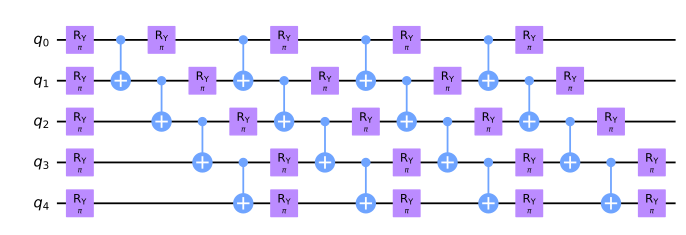

In [8]:
circuit_grid_model = CircuitGridModel(NUM_QUBITS, 21)
circuit = circuit_grid_model.compute_circuit_simple()
expectation_grid = ExpectationGrid(circuit, initial_adj_matrix)
array_to_latex(initial_adj_matrix, pretext="\\text{Adjacency Matrix = }\n")
display(circuit.draw(output='mpl',scale=0.9,justify="left"))

## Main Loop and Print Results
First extract all nodes with gates suitable for rotation ans intialize first rotation of those with $\pi$. At the beginning, all Ry Gates will be indeed Pauli Y Gates.

After that we will run the first Optimization iteration befor going to the actual main loop.

In the main loop showing as a `while` we will **print** the Iteration number, the rotating gate, the position in the 5x21 matrix, the energy of this iteration, and the optimal basis state so far.

Then we will try to **optimize** calling `optimize_rotations` function. During the optimization we will also print the simulated Ansatz State that results after the optimization quantum circuit. The output will be a **sum of the basis states and its probability**.

Once the optimization comes to an end and we get out of the loop we will print the final Energy and Optimal Base State as a result

In [9]:
rotation_gate_nodes = circuit_grid_model.get_rotation_gate_nodes()
optimized_rotations = np.full(len(rotation_gate_nodes), np.pi)
num_times_rot_dir_change = np.zeros(len(optimized_rotations))

min_distance, basis_state_str = calc_new_energy(circuit_grid_model, expectation_grid, rotation_gate_nodes)
    
while not Fin_optimizacion:
    if cur_rotation_num != len(optimized_rotations):
        print(' Iteration #' + str(iteration+1) , ', Rotating Gate #' , str(cur_rotation_num+1) , 
        '(Wire, Column) = (', rotation_gate_nodes[cur_rotation_num].wire_num+1, ',' , 
        rotation_gate_nodes[cur_rotation_num].column_num+1, '). Energy:', "{:.6f}".format(np.real(min_distance)), 
        ', Best Basis State:', basis_state_str, "\n")

    min_distance, basis_state_str = optimize_rotations(circuit_grid_model, expectation_grid, rotation_gate_nodes)
    iteration +=  1

print("\n-------------------------------------------------------- \n")
print('Final Energy: ', "{:.6f}".format(np.real(min_distance)), ', Optimal Basis State:', basis_state_str)
print("\n-------------------------------------------------------- \n")


 Ansatz Quantum State = 1.00*|00111> 
 Iteration #1 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.000000 , Best Basis State: 00111 

 Ansatz Quantum State = 0.96*|00111> + 0.04*|10110> 
 Iteration #2 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.038060 , Best Basis State: 00111 

 Ansatz Quantum State = 0.85*|00111> + 0.15*|10110> 
 Iteration #3 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.146447 , Best Basis State: 00111 

 Ansatz Quantum State = 0.69*|00111> + 0.31*|10110> 
 Iteration #4 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.308658 , Best Basis State: 00111 

 Ansatz Quantum State = 0.50*|00111> + 0.50*|10110> 
 Iteration #5 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.500000 , Best Basis State: 00111 

 Ansatz Quantum State = 0.31*|00111> + 0.69*|10110> 
 Iteration #6 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.691342 , Best Basis State: 10110 

 Ansatz Quantum State = 0.15*|00111> + 0.85*|1011

 Iteration #62 , Rotating Gate # 13 (Wire, Column) = ( 3 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Ansatz Quantum State = 0.04*|00001> + 0.96*|10101> 
 Iteration #63 , Rotating Gate # 13 (Wire, Column) = ( 3 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Iteration #64 , Rotating Gate # 14 (Wire, Column) = ( 4 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Ansatz Quantum State = 0.96*|10101> + 0.04*|11101> 
 Iteration #65 , Rotating Gate # 14 (Wire, Column) = ( 4 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Ansatz Quantum State = 0.96*|10101> + 0.04*|11101> 
 Iteration #66 , Rotating Gate # 14 (Wire, Column) = ( 4 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Iteration #67 , Rotating Gate # 15 (Wire, Column) = ( 5 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Ansatz Quantum State = 0.04*|00101> + 0.96*|10101> 
 Iteration #68 , Rotating Gate # 15 (Wire, Column) = ( 5 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Ansatz Qua

---
Next in **Part (II)** we will explore how to do a full quantum circuit to evaluate the energy final step without "cheating". For that we will first explore a "Brute force" Measurement.

In **Part (III)** we will go beyond with the [Hadamard test](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)).

---
This code was mostly based on Qiskit Variational Quantum Eigensolver Playground, you can find in [Github](https://github.com/JavaFXpert/vqe-playground). You can find the complete code with a fantastic visualization based on pygame.

---